# Example Notebook for Keysight Network Analyzers

This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight network analyzers. The driver is implemented to be generic as possible, with individual instrument drivers filling in only the hardware limits of the instrument, so although this example uses the N5245A, the concepts and code should work for any keysight network analyzer.

In [1]:
%matplotlib inline

In [2]:
# Import Dependencies

import numpy as np 
import logging
import matplotlib.pyplot as plt

# qcodes imports
import qcodes as qc
from qcodes.dataset.data_set import new_data_set
from qcodes.dataset.experiment_container import new_experiment, load_experiment_by_name
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument_drivers.Keysight.N5222B import N5222B

In [3]:
qc.initialise_database()

# Start experiment
exp_name = 'PNA_Example_N5222B'
sample_name = 'sample_bar_code'
try:
    exp = load_experiment_by_name(exp_name, sample=sample_name)
    print('Experiment loaded. Last ID no:', exp.last_counter)
except ValueError:
    exp = new_experiment(exp_name, sample_name)
    print('Starting new experiment.')

Experiment loaded. Last ID no: 38


## Connect to the instrument

You will have to insert the correct VISA address for your PNA below. On my PC, the PNA has IP address `192.168.0.10`. You can generally use NI MAX or Agilent IO Toolkit to figure out what the VISA address of your instrument is, particularly for USB or GPIB connections.

In [4]:
pna = N5222B('pna', 'GPIB0::16::INSTR')

Connected to: Keysight Technologies N5222B (serial:MY57041028, firmware:A.13.25.04) in 0.16s


## Managing traces 

A weakness of the old driver is that it cannot define new traces on the instrument, nor make a trace on a particular channel. 

In [5]:
pna.delete_all_traces()

In [6]:
pna.channel[0].trace

{}

NB: If we manually add a trace to the intrument this will be shown here as well

In [7]:
trace = pna.channel[0].add_trace("T_S11", "S11")  # Let's make a S11 trace on channel 1. The name of this trace is T_S11

In [8]:
pna.channel[0].trace

{'T_S11': T_S11, S11}

In [9]:
print(trace)

T_S11, S11


In [10]:
pna.channel[1].trace  # List the traces on channel 2. We see that there are none 

{}

In [11]:
# We can delete a trace 
pna.channel[0].trace["T_S11"].delete()
print(pna.channel[0].trace)

{}


In [12]:
# Alternatively, we can delete a trace like so
if "T_S11" in pna.channel[0].trace: 
    pna.channel[0].delete_trace("T_S11")

## Measuring

Below we see how we can perform a measurement

Starting experimental run with id: 53


([<matplotlib.axes._subplots.AxesSubplot at 0x149050a1668>,
 [None, None, None])

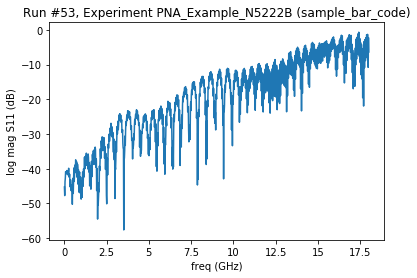

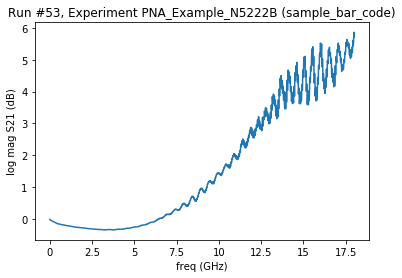

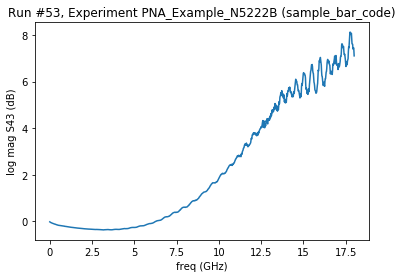

In [13]:
trace_s21 = pna.channel[0].add_trace("T_S21", "S21")  # We need a trace in the rest of the notebook so lets add one again 
trace_s11 = pna.channel[0].add_trace("T_S11", "S11")
trace_s43 = pna.channel[0].add_trace("T_S43", "S43")

# Run a measurement
fstart = 10e6  # Hz
fstop = 18e9 # Hz 
points = 1001

freq = np.linspace(fstart, fstop, points)

pna.power(10)
pna.start(fstart)
pna.stop(fstop)
pna.points(points)

meas = Measurement()
meas.register_custom_parameter(name="frequency", label="freq", unit="Hz")
meas.register_custom_parameter(name="log_magnitude_s11", label="log mag S11", unit="dB", setpoints=["frequency"])
meas.register_custom_parameter(name="log_magnitude_s21", label="log mag S21", unit="dB", setpoints=["frequency"])
meas.register_custom_parameter(name="log_magnitude_s43", label="log mag S43", unit="dB", setpoints=["frequency"])

with meas.run() as datasaver:
    pna.channel[0].run_sweep(averages=2)
    
    datasaver.add_result(("frequency", freq), ("log_magnitude_s11", trace_s11.log_magnitude()))
    datasaver.add_result(("frequency", freq), ("log_magnitude_s21", trace_s21.log_magnitude()))
    datasaver.add_result(("frequency", freq), ("log_magnitude_s43", trace_s43.log_magnitude()))
    
plot_by_id(datasaver.run_id)